In [1]:
import cv2
import dlib
import os
import numpy as np
import matplotlib.pyplot as plt
face_detector = dlib.get_frontal_face_detector()
from keras.applications.xception import preprocess_input
from keras import models
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd


Using TensorFlow backend.


In [2]:
model_Xc = models.load_model('model_finetuned_xception.hdf5') # 


def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    #Reference: https://github.com/ondyari/FaceForensics
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left() # Taking lines numbers around face
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale) # scaling size of box to 1.3
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

def get_predicition(image):
    """Expects the image input, this image further cropped to face
    and the cropped face image will be sent for evalution funtion 
    finally 
    returns the annotated reusult with bounding box around the face. 
    """
    df=[]
    height, width = image.shape[:2]
    try: # If in case face is not detected at any frame
        face = face_detector(image, 1)[0]  # Face detection
        x, y, size = get_boundingbox(face=face, width=width, height=height) # Calling to get bound box around the face
    except IndexError:
        print('indexError')
        pass
    cropped_face = image[y:y+size, x:x+size] # cropping the face 
    output,label = evaluate(cropped_face) # Sending the cropped face to get classifier result 
    #df.append([label,output])
    font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
    thickness = 2
    font_scale = 1
    if label=='Real':
        color = (0,255, 0)
    else:
        color = (0, 0, 255)
    x = face.left()    # Setting the bounding box on uncropped image
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    cv2.putText(image, label+'_'+str('%.2f'%output)+'%', (x, y+h+30), 
            font_face, font_scale,
            color, thickness, 2) # Putting the label and confidence values

    return cv2.rectangle(image, (x, y), (x + w, y + h), color, 2),output,label # draw box over face

def evaluate(cropped_face):
    """This function classifies the cropped  face on loading the trained model
    and 
    returns the label and confidence value
    """        
    img = cv2.resize(cropped_face, (299, 299))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img) 
    res = model_Xc.predict(img)[0]
    if np.argmax(res)==1:
        label = 'Fake'
    else:
        label = 'Real'
    return res[np.argmax(res)]*100.0, label


def final_model(video_path,limit_frames):
        """Expects the video path : '/xxx.mp4'
        limit_frames : total number frames to be taken from input video 
         function will write the video with 
        classification results and place the output video in the pwd"""
        output_ = video_path.split("/")[-1].split(".")[-2]
        #scores_list=pd.DataFrame(columns=['result','score'])
        scores=[]
        labels=[]
        capture = cv2.VideoCapture(video_path)
      
        if capture.isOpened():
           
                _,image = capture.read()
                frame_width = int(capture.get(3))
                frame_height = int(capture.get(4))
                out = cv2.VideoWriter(output_+'_output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
        else:
                _ = False
        i=1
        df_length = 0
        
        while (_):
                _, image = capture.read()
                classified_img,score,label = get_predicition(image)

                out.write(classified_img)
                scores.append(score)
                labels.append(label)
#                 df_length = len(scores_list)
#                 scores_list.loc[df_length] = score
                if i%10 == 0:
                    print("Number of frames complted:{}".format(i))
                if i==limit_frames:
                        break
                i=i+1
        capture.release()
        result_df = pd.DataFrame({'Score':scores,'Label':labels})
        result_df.reset_index(inplace=True)
        result_df['convert_Label']=np.where(result_df['Label']=='Real',1, -1)
        result_df['convert_score'] = result_df['Score']*result_df['convert_Label']
        return result_df

In [98]:
#For testing any new video
fake_video1=final_model(video_path='video_test/fake_video.mp4',
            limit_frames=300)

fake_video1.plot(x="index", y="convert_score",kind="line",figsize=(8, 4))
plt.ylabel('converted_confidence_score')
plt.title('fake_video1')
plt.show()

Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
Number of frames complted:210
Number of frames complted:220
Number of frames complted:230
Number of frames complted:240
Number of frames complted:250
Number of frames complted:260
Number of frames complted:270
Number of frames complted:280
Number of frames complted:290
Number of frames complted:300


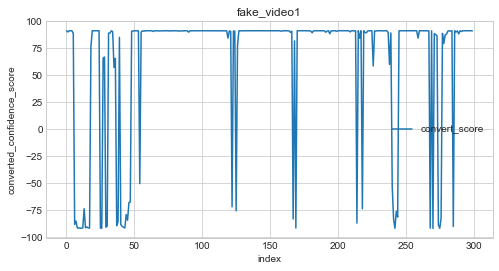

In [100]:
fake_video1.plot(x="index", y="convert_score",kind="line",figsize=(8, 4))
plt.ylabel('converted_confidence_score')
plt.title('fake_video1')
plt.show()

In [103]:
#For testing any new video
fake_video3=final_model(video_path='video_test/fake_video3.mp4',
            limit_frames=70)



Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70


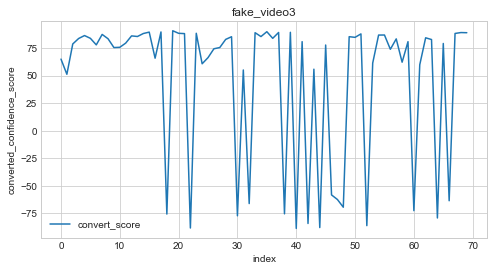

In [105]:
fake_video3.plot(x="index", y="convert_score",kind="line",figsize=(8, 4))
plt.ylabel('converted_confidence_score')
plt.title('fake_video3')
plt.show()

In [106]:
#For testing any new video
test_video=final_model(video_path='video_test/test_video.mp4',
            limit_frames=300)


Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
Number of frames complted:210
Number of frames complted:220
Number of frames complted:230
Number of frames complted:240
Number of frames complted:250
Number of frames complted:260
Number of frames complted:270
Number of frames complted:280
Number of frames complted:290
Number of frames complted:300


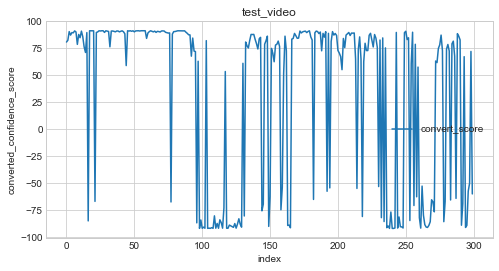

In [107]:
test_video.plot(x="index", y="convert_score",kind="line",figsize=(8, 4))
plt.ylabel('converted_confidence_score')
plt.title('test_video')
plt.show()

In [110]:
#For testing any new video
video_real5=final_model(video_path='video_test/video_real5.mp4',
            limit_frames=40)


Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40


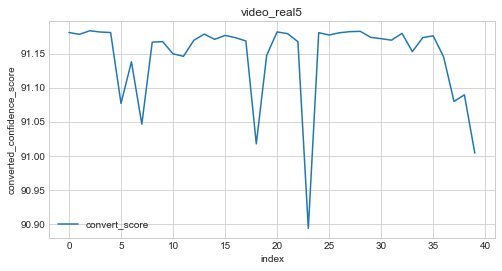

In [111]:
video_real5.plot(x="index", y="convert_score",kind="line",figsize=(8, 4))
plt.ylabel('converted_confidence_score')
plt.title('video_real5')
plt.show()

In [120]:
#For testing any new video
video_real=final_model(video_path='video_test/video_real.mp4',
            limit_frames=300)


Number of frames complted:10
Number of frames complted:20
Number of frames complted:30
Number of frames complted:40
Number of frames complted:50
Number of frames complted:60
Number of frames complted:70
Number of frames complted:80
Number of frames complted:90
Number of frames complted:100
Number of frames complted:110
Number of frames complted:120
Number of frames complted:130
Number of frames complted:140
Number of frames complted:150
Number of frames complted:160
Number of frames complted:170
Number of frames complted:180
Number of frames complted:190
Number of frames complted:200
Number of frames complted:210
Number of frames complted:220
Number of frames complted:230
Number of frames complted:240
Number of frames complted:250
Number of frames complted:260
Number of frames complted:270
Number of frames complted:280
Number of frames complted:290
Number of frames complted:300


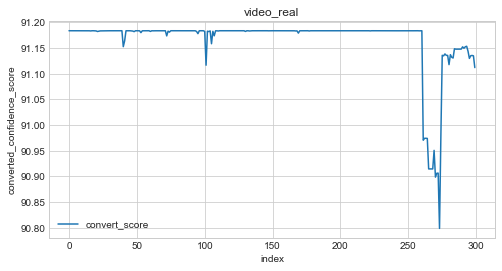

In [121]:
video_real.plot(x="index", y="convert_score",kind="line",figsize=(8, 4))
plt.ylabel('converted_confidence_score')
plt.title('video_real')
plt.show()